In [23]:
!pip install statsmodels

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [23]:
df = pd.read_csv('btc_eth_ltc.csv',index_col='Date')

In [24]:
df = df.sort_values('Date')
df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,ETHUSD,202.67,207.89,202.50,205.86,21165.529375
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-16 04:00:00,1539662400000,BTCUSD,6423.27,6489.99,6390.10,6444.08,2978.589591
2018-10-17 04:00:00,1539748800000,BTCUSD,6444.08,6487.77,6406.98,6459.26,1998.462064
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
...,...,...,...,...,...,...,...
2021-09-21 04:00:00,1632196800000,ETHUSD,2998.29,3104.42,2650.85,2869.31,46289.916678
2021-09-21 04:00:00,1632196800000,LTCUSD,159.47,162.20,144.62,151.48,46606.739750
2021-09-22 04:00:00,1632283200000,BTCUSD,42089.88,44047.48,41836.59,43559.58,1051.581492


In [25]:
df['Symbol'].unique()

array(['ETHUSD', 'LTCUSD', 'BTCUSD'], dtype=object)

In [26]:
df.groupby('Symbol')['Unix Timestamp'].nunique()

Symbol
BTCUSD    1073
ETHUSD    1073
LTCUSD    1073
Name: Unix Timestamp, dtype: int64

<BarContainer object of 3 artists>

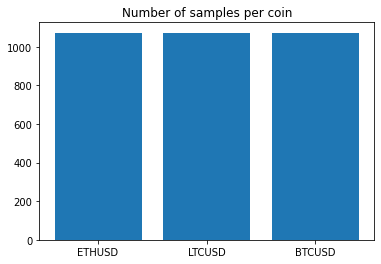

In [27]:
plt.title('Number of samples per coin')
plt.bar(df['Symbol'].unique(),df.groupby('Symbol')['Unix Timestamp'].nunique())

In [88]:
#Split dataframes
list_df = {}
for name in df['Symbol'].unique():
    print(name)
    list_df.update({name:df[df.Symbol==name]})

ETHUSD
LTCUSD
BTCUSD


In [89]:
ltc_df = list_df.get('LTCUSD')
btc_df = list_df.get('BTCUSD')
eth_df = list_df.get('ETHUSD')


In [90]:
ltc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
2018-10-18 04:00:00,1539835200000,LTCUSD,53.52,53.87,51.25,51.88,3150.270139
2018-10-19 04:00:00,1539921600000,LTCUSD,51.88,51.88,51.88,51.88,0.000000
2018-10-20 04:00:00,1540008000000,LTCUSD,51.88,52.75,51.88,52.75,1.000000
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,LTCUSD,182.08,185.74,178.43,179.44,21093.113429
2021-09-19 04:00:00,1632024000000,LTCUSD,179.44,181.60,163.50,167.01,31279.361709
2021-09-20 04:00:00,1632110400000,LTCUSD,167.01,168.18,150.22,159.47,86803.808889


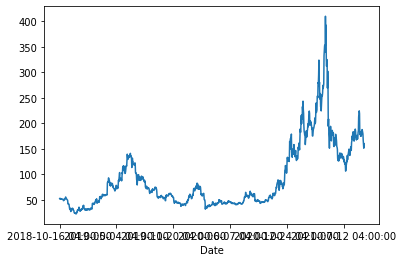

In [54]:
ltc_df['Close'].plot()

In [73]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa import arima_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# load dataset



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [69]:
# fit model
def train_arima(df):
    series = pd.DataFrame(df['Close'])
    series.index = pd.to_datetime(series.index)
    series.index = series.index.to_period('M')
    model = arima_model.ARIMA(series, order=(2,1,0))
    model_fit = model.fit()
    # summary of fit model
    print(model_fit.summary())
    # line plot of residuals
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    pyplot.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    pyplot.show()
    # summary stats of residuals
    print(residuals.describe())
    return series

In [77]:
def predict_arima(series):
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
      model = arima_model.ARIMA(history, order=(5,1,0))
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      obs = test[t]
      history.append(obs)
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

In [148]:
def forecast_arima(df,months=7):
    import datetime
    series = pd.DataFrame(df['Close'])
    series.index = pd.to_datetime(series.index)
    max = series.index.max()

    series.index = series.index.to_period('M')
    X = series.values
    history = [x for x in X]
    predictions = pd.DataFrame(columns=['date','Close'])
    # walk-forward validation
    for t in range(months):
      model = arima_model.ARIMA(history, order=(2,1,0))
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      predictions=pd.concat([predictions,pd.DataFrame([[max+datetime.timedelta(days=t*30),yhat[0]]],columns=['date','Close'])])
      obs = test[t]
      history.append(obs)
    predictions.index = predictions['date']
    predictions.drop('date',axis=1,inplace=True)
    return predictions

## LTC

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1072
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3740.587
Method:                       css-mle   S.D. of innovations              7.928
Date:                Wed, 29 Sep 2021   AIC                           7489.175
Time:                        15:21:27   BIC                           7509.084
Sample:                    10-31-2018   HQIC                          7496.716
                         - 09-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0989      0.216      0.457      0.648      -0.325       0.523
ar.L1.D.Close    -0.1748      0.030     -5.731      0.000      -0.235      -0.115
ar.L2.D.Close     0.0555      0.030     

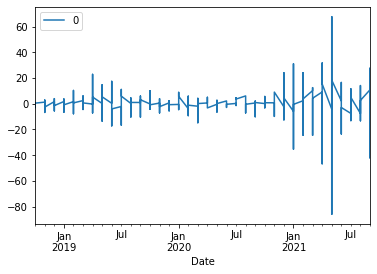

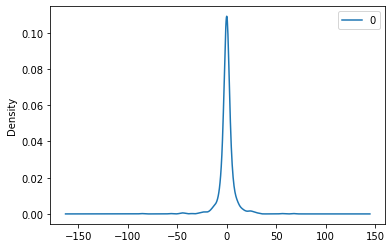

                 0
count  1072.000000
mean      0.000151
std       7.931665
min     -86.059031
25%      -1.824875
50%      -0.080770
75%       1.846670
max      67.710549


In [149]:
series = train_arima(ltc_df)

Test RMSE: 13.216


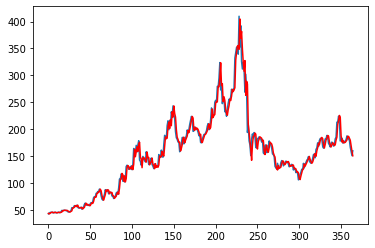

In [150]:
predict_arima(series)

In [151]:
pred =forecast_arima(ltc_df,months=7) #monthly forecast
pred

,Close
date,
2021-09-22 04:00:00,158.491891
2021-10-22 04:00:00,65.999487
2021-11-21 04:00:00,36.370725
2021-12-21 04:00:00,45.949692
2022-01-20 04:00:00,46.255797
2022-02-19 04:00:00,46.686266
2022-03-21 04:00:00,45.778992


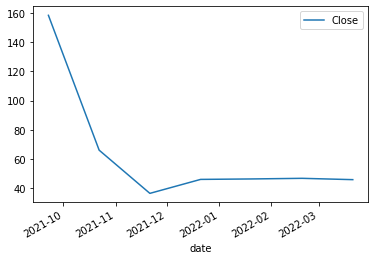

In [152]:
pred.plot()

In [136]:
ltc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
2018-10-18 04:00:00,1539835200000,LTCUSD,53.52,53.87,51.25,51.88,3150.270139
2018-10-19 04:00:00,1539921600000,LTCUSD,51.88,51.88,51.88,51.88,0.000000
2018-10-20 04:00:00,1540008000000,LTCUSD,51.88,52.75,51.88,52.75,1.000000
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,LTCUSD,182.08,185.74,178.43,179.44,21093.113429
2021-09-19 04:00:00,1632024000000,LTCUSD,179.44,181.60,163.50,167.01,31279.361709
2021-09-20 04:00:00,1632110400000,LTCUSD,167.01,168.18,150.22,159.47,86803.808889


## BTC

In [153]:
btc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,BTCUSD,6423.27,6489.99,6390.10,6444.08,2978.589591
2018-10-17 04:00:00,1539748800000,BTCUSD,6444.08,6487.77,6406.98,6459.26,1998.462064
2018-10-18 04:00:00,1539835200000,BTCUSD,6459.26,6459.64,6350.92,6383.39,4597.200330
2018-10-19 04:00:00,1539921600000,BTCUSD,6383.39,6383.39,6383.39,6383.39,0.000000
2018-10-20 04:00:00,1540008000000,BTCUSD,6383.39,6386.34,6382.00,6382.04,2.701644
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,BTCUSD,47962.79,48808.97,47613.93,47854.23,671.356150
2021-09-19 04:00:00,1632024000000,BTCUSD,47854.23,48333.32,45175.20,45553.62,860.712331
2021-09-20 04:00:00,1632110400000,BTCUSD,45553.62,45837.90,40137.98,42688.03,4373.379477


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1072
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8957.439
Method:                       css-mle   S.D. of innovations           1029.551
Date:                Wed, 29 Sep 2021   AIC                          17922.877
Time:                        15:24:28   BIC                          17942.786
Sample:                    10-31-2018   HQIC                         17930.418
                         - 09-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.6227     29.445      1.176      0.240     -23.089      92.334
ar.L1.D.Close    -0.0788      0.031     -2.579      0.010      -0.139      -0.019
ar.L2.D.Close     0.0108      0.031     

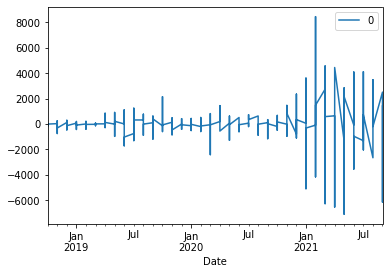

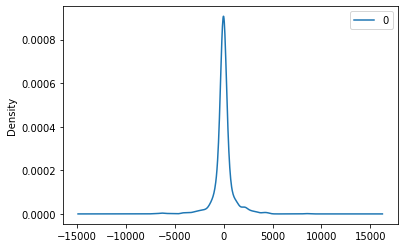

                 0
count  1072.000000
mean     -0.097389
std    1030.031445
min   -7111.521593
25%    -200.732040
50%     -20.780492
75%     206.470951
max    8452.496195


In [154]:
series = train_arima(btc_df)

Test RMSE: 1744.344


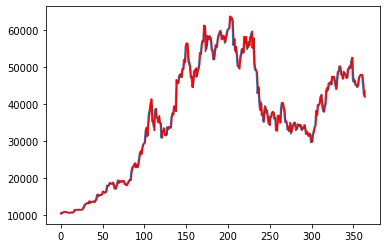

In [155]:
predict_arima(series)

In [156]:
pred =forecast_arima(btc_df,months=7) #monthly forecast
pred

,Close
date,
2021-09-22 04:00:00,43474.310180
2021-10-22 04:00:00,5805.538476
2021-11-21 04:00:00,-1457.037732
2021-12-21 04:00:00,39.883806
2022-01-20 04:00:00,40.046457
2022-02-19 04:00:00,40.591768
2022-03-21 04:00:00,39.472442


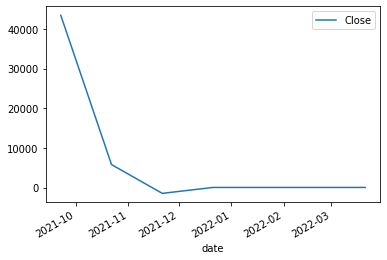

In [157]:
pred.plot()

In [158]:
btc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,BTCUSD,6423.27,6489.99,6390.10,6444.08,2978.589591
2018-10-17 04:00:00,1539748800000,BTCUSD,6444.08,6487.77,6406.98,6459.26,1998.462064
2018-10-18 04:00:00,1539835200000,BTCUSD,6459.26,6459.64,6350.92,6383.39,4597.200330
2018-10-19 04:00:00,1539921600000,BTCUSD,6383.39,6383.39,6383.39,6383.39,0.000000
2018-10-20 04:00:00,1540008000000,BTCUSD,6383.39,6386.34,6382.00,6382.04,2.701644
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,BTCUSD,47962.79,48808.97,47613.93,47854.23,671.356150
2021-09-19 04:00:00,1632024000000,BTCUSD,47854.23,48333.32,45175.20,45553.62,860.712331
2021-09-20 04:00:00,1632110400000,BTCUSD,45553.62,45837.90,40137.98,42688.03,4373.379477


## ETH

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1072
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6086.692
Method:                       css-mle   S.D. of innovations             70.735
Date:                Wed, 29 Sep 2021   AIC                          12181.385
Time:                        15:26:14   BIC                          12201.294
Sample:                    10-31-2018   HQIC                         12188.926
                         - 09-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.6651      2.125      1.254      0.210      -1.499       6.829
ar.L1.D.Close    -0.0651      0.031     -2.128      0.034      -0.125      -0.005
ar.L2.D.Close     0.0483      0.031     

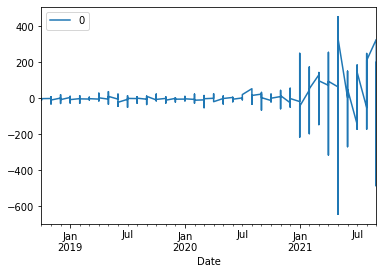

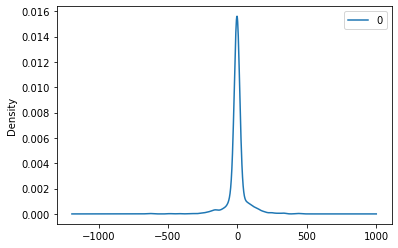

                 0
count  1072.000000
mean     -0.000004
std      70.768112
min    -643.389535
25%      -8.032842
50%      -2.017349
75%       6.897299
max     453.827690


In [159]:
series = train_arima(eth_df)

Test RMSE: 125.060


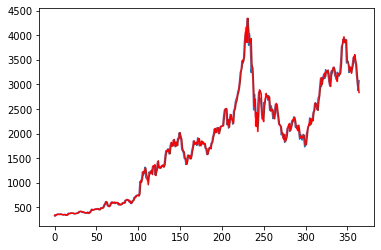

In [160]:
predict_arima(series)

In [161]:
pred =forecast_arima(eth_df,months=7) #monthly forecast
pred

,Close
date,
2021-09-22 04:00:00,3055.691797
2021-10-22 04:00:00,587.553161
2021-11-21 04:00:00,-302.786550
2021-12-21 04:00:00,45.919420
2022-01-20 04:00:00,46.100863
2022-02-19 04:00:00,46.595386
2022-03-21 04:00:00,45.510576


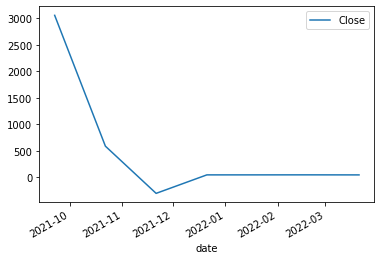

In [162]:
pred.plot()

In [163]:
eth_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,ETHUSD,202.67,207.89,202.50,205.86,21165.529375
2018-10-17 04:00:00,1539748800000,ETHUSD,205.86,206.05,201.35,204.60,11431.196005
2018-10-18 04:00:00,1539835200000,ETHUSD,204.60,204.78,196.97,199.43,24540.877376
2018-10-19 04:00:00,1539921600000,ETHUSD,199.43,199.43,199.43,199.43,0.000000
2018-10-20 04:00:00,1540008000000,ETHUSD,199.43,200.73,199.43,200.73,4.687530
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,ETHUSD,3452.36,3541.89,3374.61,3413.18,7627.867957
2021-09-19 04:00:00,1632024000000,ETHUSD,3413.18,3458.96,3157.41,3187.56,15668.045794
2021-09-20 04:00:00,1632110400000,ETHUSD,3187.56,3218.18,2807.97,2998.29,49242.010484
